# Characteristic Time Scales (Solutions)

<div class="alert alert-block alert-info"> In this notebook, you will play with parameters of the implemented theory (mass, sound speed and quadratic mixing) to try to understand what is the bulk dynamics of the fields as we move in the parameter space. </div>

In [1]:
# Import the standard Python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time

# For Latex-style labels
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import CosmoFlow modules (they must be located in the same parent folder as this notebook)
from Parameters import parameters
from Theory import theory
from Solver import solver

In [2]:
# Define the numerical i\epsilon prescription
def adiabatic(N_load, DeltaN):
    return (np.tanh((N_load + DeltaN - 1)/0.1) + 1)/2

<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a function horizons(cs, m, rho) that takes the sound speed, the mass and the quadratic mixing strength as inputs, and outputs the number of $e$-folds array N and the array f where all correlators as function of time are stored. </div>

In [11]:
def horizons(cs, m, rho):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-10, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 4.5 # Number of e-folds before horizon crossing
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = cs * np.ones(n) # Speed of sound for phi
    m_load = m * np.ones(n) # Mass of Psi
    rho_load = rho * np.ones(n) * adiabatic(N_load, DeltaN) # Linear mixing strength
    g_load = 1 * np.ones(n) * adiabatic(N_load, DeltaN) # Cubic coupling
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, g_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-4, 1e-180 # Relative and absolute tolerance of the integrator
    N_exit = 0 # Horizon exit for a mode
    Ni, Nf = N_exit - DeltaN, 5 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    k = theo.k_mode(N_exit) # Mode corresponding to N = 0 horizon exit
    k1, k2, k3 = k, k, k # Kinematic configuration for 3-pt function (here equilateral)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    return N, f

## Sound Horizon Crossing

<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a script that produces a figure showing the two- and three-point correlators (in equilateral kinematic configuration) as function of time, varying cs from $0.1$ to $1$ with $10$ points. We will fix $m/H=2$ and $\rho/H=0.1$. 
    <ul>
    <li>What do you notice?</li>
    <li>The code is slower or faster when we decrease the sound speed?</li></li>
  </ul>
</div>

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:116: RuntimeWarning: invalid value encountered in scalar divide
  d2 = norm((f1 - f0) / scale) / h0


Text(0, 0.5, "$\\langle\\varphi^2\\rangle'$, $\\langle\\varphi_{\\bm{k}_1} \\varphi_{\\bm{k}_2} \\varphi_{\\bm{k}_3}\\rangle'$")

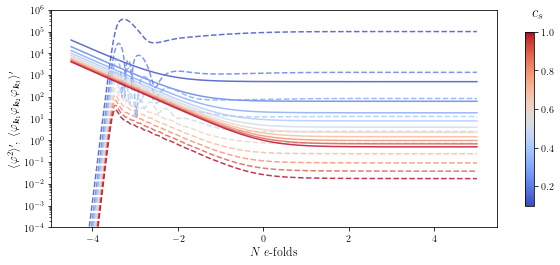

In [22]:
# Define figure
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot()

# Axis limits
ax.set_ylim([1e-4, 1e6])

# cs range
cs_min = 0.1
cs_max = 1
cs_number = 10
cs = np.linspace(cs_min, cs_max, cs_number)

#Initialize min and max value for cs
norm = matplotlib.colors.Normalize(vmin = (cs_min), vmax = (cs_max))
#Choose a colormap
c_m = matplotlib.cm.coolwarm
#Initialize the colorbar
s_m = matplotlib.cm.ScalarMappable(cmap = c_m, norm = norm)
s_m.set_array([])
cb = plt.colorbar(s_m, ax = ax, shrink = 0.8)
#Colorbar label with position
cb.set_label("$c_s$", y = 1.15, rotation = 0, labelpad = -16, fontsize = 15)


#Loop on cs values
for i in range(len(cs)):
    N, f = horizons(cs[i], m = 2, rho = 0.1)
    ax.semilogy(N, np.abs(f[0][0, 0]), color = s_m.to_rgba(cs[i]), alpha = 0.8, ls = "-")
    ax.semilogy(N, np.abs(f[6][0, 0, 0]), color = s_m.to_rgba(cs[i]), alpha = 0.8, ls = "--")

# Labels
ax.set_xlabel(r"$N$ $e$-folds", fontsize = 12)
ax.set_ylabel(r"$\langle\varphi^2\rangle''$, $'\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$", fontsize = 12)


<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a script that produces a figure showing the freez-out time ($e$-fold value relative to horizon crossing a $N=0$) as function of $\log_{10}(c_s)$. We will fix $m/H=2$ and $\rho/H=0.1$ and logarithmically scan 10 values of $c_s$ between $0.1$ and 1. Comment. 
    
Hint: To get the freeze-out time, you will store the first array index i for which two consecutive values of the massless field two-point function reach the $10^{-2}$ threshold.
</div>

-1.9704704704704703
-1.2762762762762758
-0.8768768768768767
-0.5820820820820818
-0.36336336336336306
-0.18268268268268262
-0.030530530530530342
0.10260260260260257
0.22622622622622668
0.3308308308308314


Text(0, 0.5, 'Freeze-out time')

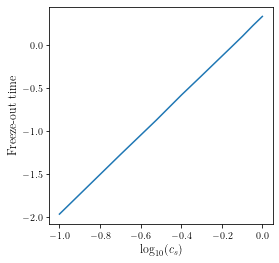

In [30]:
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot()

# cs range
cs_min = 0.1
cs_max = 1
cs_number = 10
cs = np.linspace(cs_min, cs_max, cs_number)

# Array storing time of mode freezing
tol = 1e-2
FreezeOut = []

#Loop on cs values
for i in range(len(cs)):
    N, f = horizons(cs[i], m = 2, rho = 0.1)
    TwoPoint = np.abs(f[0][0, 0])
    TwoPoint = TwoPoint/TwoPoint[-1]
    for j in range(1, len(TwoPoint)):
        if abs(TwoPoint[j] - TwoPoint[j - 1]) <= tol:
            FreezeOut.append(N[j])
            print(N[j])
            break
            
FreezeOut = np.asarray(FreezeOut)
    
ax.plot(np.log10(cs), FreezeOut)
ax.set_xlabel(r"$\log_{10}(c_s)$", fontsize = 12)
ax.set_ylabel(r"Freeze-out time", fontsize = 12)


## Strong Mixing Horizon Crossing

<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a script that produces a figure showing the two- and three-point correlators (in equilateral kinematic configuration) as function of time, varying $\rho/H$ from $0.1$ to $10$ with $10$ points. We will fix $c_s=1$ and $m/H=2$. 
    <ul>
    <li>What do you notice for the two-point function of $\varphi$ on sub-horizon scales?</li>
    <li>What do you notice for the three-point function of $\varphi$ on sub-horizon scales? Explain.</li>
  </ul>
</div>

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:116: RuntimeWarning: invalid value encountered in scalar divide
  d2 = norm((f1 - f0) / scale) / h0


Text(0, 0.5, "$\\langle\\varphi^2\\rangle''$, $'\\langle\\varphi_{\\bm{k}_1} \\varphi_{\\bm{k}_2} \\varphi_{\\bm{k}_3}\\rangle'$")

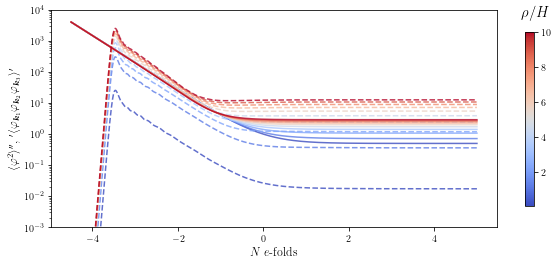

In [33]:
# Define figure
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot()

# Axis limits
ax.set_ylim([1e-3, 1e4])

# rho range
rho_min = 0.1
rho_max = 10
rho_number = 10
rho = np.linspace(rho_min, rho_max, rho_number)

#Initialize min and max value for rho
norm = matplotlib.colors.Normalize(vmin = (rho_min), vmax = (rho_max))
#Choose a colormap
c_m = matplotlib.cm.coolwarm
#Initialize the colorbar
s_m = matplotlib.cm.ScalarMappable(cmap = c_m, norm = norm)
s_m.set_array([])
cb = plt.colorbar(s_m, ax = ax, shrink = 0.8)
#Colorbar label with position
cb.set_label("$\\rho/H$", y = 1.15, rotation = 0, labelpad = -16, fontsize = 15)


#Loop on rho values
for i in range(len(rho)):
    N, f = horizons(cs = 1, m = 2, rho = rho[i])
    ax.semilogy(N, np.abs(f[0][0, 0]), color = s_m.to_rgba(rho[i]), alpha = 0.8, ls = "-")
    ax.semilogy(N, np.abs(f[6][0, 0, 0]), color = s_m.to_rgba(rho[i]), alpha = 0.8, ls = "--")

# Labels
ax.set_xlabel(r"$N$ $e$-folds", fontsize = 12)
ax.set_ylabel(r"$\langle\varphi^2\rangle''$, $'\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$", fontsize = 12)


## Squeezing the Bispectrum

<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a function squeezed(kappa) that takes the squeezing ratio kappa as inputs, and outputs the number of $e$-folds array N and the array f where all correlators as function of time are stored. We will consider cs=1, m/H=2 and rho/H=0.1. </div>

In [34]:
def squeezed(kappa):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-10, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 4.5 # Number of e-folds before horizon crossing
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = 1 * np.ones(n) # Speed of sound for phi
    m_load = 2 * np.ones(n) # Mass of Psi
    rho_load = 0.1 * np.ones(n) * adiabatic(N_load, DeltaN) # Linear mixing strength
    g_load = 1 * np.ones(n) * adiabatic(N_load, DeltaN) # Cubic coupling
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, g_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-4, 1e-180 # Relative and absolute tolerance of the integrator
    N_exit = 0 # Horizon exit for a mode
    Ni, Nf = N_exit - DeltaN, 5 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    k = theo.k_mode(N_exit) # Mode corresponding to N = 0 horizon exit
    k1, k2, k3 = k, k/kappa, k/kappa # Kinematic configuration for 3-pt function (here equilateral)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    return N, f

<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a script that produces a figure showing the three-point correlators as function of the time, varying the squeezing ratio kappa from $1$ to $0.1$ with $5$ points. 
    <ul>
    <li>What do you notice? Explain.</li>
  </ul>
</div>

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:116: RuntimeWarning: invalid value encountered in scalar divide
  d2 = norm((f1 - f0) / scale) / h0


Text(0, 0.5, "$\\langle\\varphi_{\\bm{k}_1} \\varphi_{\\bm{k}_2} \\varphi_{\\bm{k}_3}\\rangle'$")

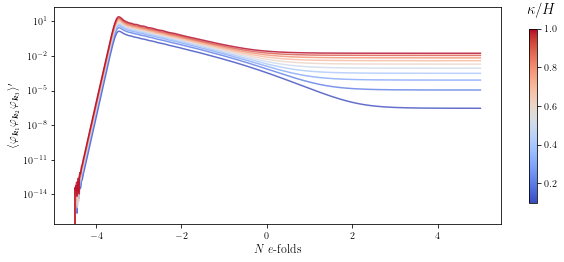

In [35]:
# Define figure
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot()

# Axis limits
#ax.set_ylim([1e-3, 1e4])

# kappa range
kappa_min = 0.1
kappa_max = 1
kappa_number = 5
kappa = np.linspace(kappa_min, kappa_max, kappa_number)

#Initialize min and max value for rho
norm = matplotlib.colors.Normalize(vmin = (kappa_min), vmax = (kappa_max))
#Choose a colormap
c_m = matplotlib.cm.coolwarm
#Initialize the colorbar
s_m = matplotlib.cm.ScalarMappable(cmap = c_m, norm = norm)
s_m.set_array([])
cb = plt.colorbar(s_m, ax = ax, shrink = 0.8)
#Colorbar label with position
cb.set_label("$\kappa/H$", y = 1.15, rotation = 0, labelpad = -16, fontsize = 15)


#Loop on rho values
for i in range(len(kappa)):
    N, f = squeezed(kappa[i])
    ax.semilogy(N, np.abs(f[6][0, 0, 0]), color = s_m.to_rgba(kappa[i]), alpha = 0.8, ls = "-")

# Labels
ax.set_xlabel(r"$N$ $e$-folds", fontsize = 12)
ax.set_ylabel(r"$\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$", fontsize = 12)


<div class="alert alert-block alert-info"> <strong>Task:</strong> Write a script that produces a figure showing the two-point correlators for two different modes as function of the time, for a squeezing parameter 0.1. 
    <ul>
    <li>What do you notice? Explain.</li>
  </ul>
</div>

Text(0, 0.5, 'Correlators')

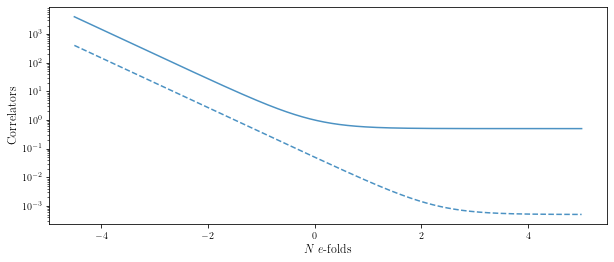

In [39]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot()


N, f = squeezed(kappa = 0.1)
ax.semilogy(N, np.abs(f[0][0, 0]), alpha = 0.8, ls = "-", color = "C0")
ax.semilogy(N, np.abs(f[1][0, 0]), alpha = 0.8, ls = "--", color = "C0")


ax.set_xlabel(r"$N$ $e$-folds", fontsize = 12)
ax.set_ylabel(r"Correlators", fontsize = 12)
